In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.10.8:46485")
client

Client Scheduler: tcp://10.32.10.8:46485 Dashboard: /user/0000-0001-6632-0187/proxy/40699/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [3]:
coords = cat.LLC4320_grid.to_dask().reset_coords()

In [12]:
coords.dxC

<xarray.DataArray 'dxC' (face: 13, j: 4320, i_g: 4320)>
dask.array<zarr, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Attributes:
    coordinate:     YC XG
    long_name:      cell x size
    standard_name:  cell_x_size_at_u_location
    units:          m

In [11]:
coords.dxC.sel(face=[0, 6], j=[1, 4, 6], i_g=[1, 2])

<xarray.DataArray 'dxC' (face: 2, j: 3, i_g: 2)>
dask.array<getitem, shape=(2, 3, 2), dtype=float32, chunksize=(1, 3, 2), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 6
  * i_g      (i_g) int64 1 2
  * j        (j) int64 1 4 6
Attributes:
    coordinate:     YC XG
    long_name:      cell x size
    standard_name:  cell_x_size_at_u_location
    units:          m

In [15]:
XCcoarse = coords.XC.coarsen(i=40, j=40).mean()
YCcoarse = coords.YC.coarsen(i=40, j=40).mean()

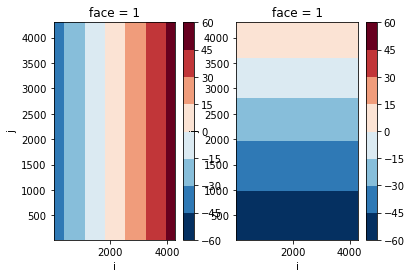

In [17]:
plt.subplot(121)
XCcoarse.isel(face=1).plot.contourf(levels=10)

plt.subplot(122)
YCcoarse.isel(face=1).plot.contourf(levels=10)

In [21]:
Xmin = XCcoarse.min(['i','j'])
Xmax = XCcoarse.max(['i','j'])

Ymin = YCcoarse.min(['i','j'])
Ymax = YCcoarse.max(['i','j'])

In [29]:
Xmin.load()
Ymin.load()
Xmax.load()
Ymax.load()

<xarray.DataArray (face: 13)>
array([-57.22757 ,  13.364231,  71.867836, -57.22757 ,  13.364231,
        71.867836,  89.76501 ,  71.86783 ,  13.364239, -57.227543,
        71.86783 ,  13.364239, -57.227543], dtype=float32)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12

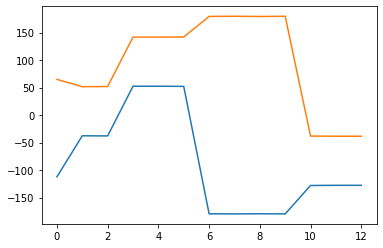

In [23]:
plt.plot(Xmin)
plt.plot(Xmax)

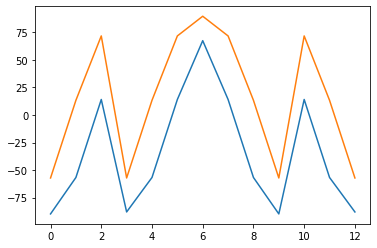

In [24]:
plt.plot(Ymin)
plt.plot(Ymax)

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

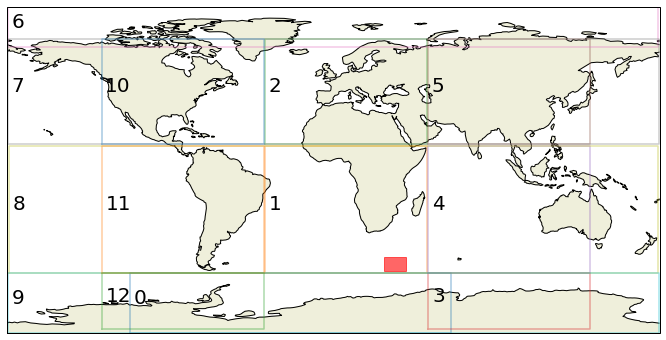

In [37]:

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

#ax.plot(x, y, marker='o', transform=ccrs.PlateCarree())
for i in range(0,13):
    Xface = [Xmin.isel(face=i), Xmax.isel(face=i), Xmax.isel(face=i), Xmin.isel(face=i), Xmin.isel(face=i)]
    Yface = [Ymin.isel(face=i), Ymin.isel(face=i), Ymax.isel(face=i), Ymax.isel(face=i), Ymin.isel(face=i)]
    
    Xmid = Xmin.isel(face=i)+2
    Ymid = 0.5*(Ymin.isel(face=i) + Ymax.isel(face=i))
    
    ax.plot(Xface, Yface, transform=ccrs.PlateCarree(), alpha=0.4)
#    ax.fill(Xface, Yface, transform=ccrs.PlateCarree(), alpha=0.4)
    ax.text(Xmid, Ymid, i, fontsize=20, transform=ccrs.PlateCarree())


x_sogos, y_sogos = [28, 40, 40, 28, 28], [-56, -56, -48, -48, -48]
ax.fill(x_sogos, y_sogos, color='red', transform=ccrs.PlateCarree(), alpha=0.6)

ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
#ax.gridlines(draw_labels=True);